## Frank Lab NWB query framework (prototype) on Allen Institute data

Note: For a more comprehensive introduction to the Frank Lab's query prototypes, see place_field_with_queries.ipynb.  Then come back to this notebook to see how these methods can be applied to Allen Institute data.

As one of the goals of NWB is to provide a common schema for neuroscience data across labs, we analyzed data from the Allen Institute using the same query and analysis code originally written to analyze Frank Lab data. See <i>place_field_with_queries.ipynb</i> for a detailed example of how we can do some canonical Frank Lab analyses using PyNWB along with a set of query classes, which we propose as an early prototype of the NWB query framework. Here, we show that these approaches can be flexibly applied to another lab's data.

To run these queries, do the following:
1. Set up a Python environment with pynwb, numpy, pandas, matplotlib, and network X installed. 
2. Download the Allen Institute NWB file 'ecephys_session_785402239.nwb'.
3. Edit the data_dir and nwb_filename variables in the second cell, such that they point to this NWB file.
4. Run the cells in order. We recommend taking time to read the docs and inspect the output along the way

In [1]:
%load_ext autoreload
%autoreload 2

# General
import os
import pynwb
import numpy as np
import pandas as pd
import networkx as nx

# Local
from nwb_query import *

# Plotting
import matplotlib.pyplot as plt

### Load the NWB File

In [2]:
data_dir = os.path.expanduser('~/Data/Allen_Inst/') 
nwb_filename = data_dir + 'ecephys_session_785402239.nwb'

io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()

print('Loaded %s' % nwb_filename)

Loaded /Users/ericmiller/Data/Allen_Inst/ecephys_session_785402239.nwb


### Analysis parameters

In [3]:
cluster_idx = 35   # which cluster to look at for single unit analyses
stim_of_interest = "static_gratings"
epoch_of_interest = 1  # 0 indexed 
speed_threshold = 50 # cm/s

### Dataset Query: Find the time intervals of all epochs and their stimulus types
#### NWBFile (one animal) --> mx2 numpy array (epoch start/stop)
In this dataset, an epoch is a single presentation of a stimulus.

In [4]:
# Extract the start/stop times of the epochs into a numpy array
# (Note: we need a method for easily extracting >1 column of a DynamicTable)
epoch_ivls_array = np.column_stack((nwbf.epochs['start_time'][:], nwbf.epochs['stop_time'][:]))

# Also get the stimulus type (i.e. stimulus_name) of each epoch
stim_types = nwbf.epochs['stimulus_name'][:]
stim_types[np.where(stim_types == '')[0]] = 'spontaneous_activity'

print("*** Epochs ***")
print("Total # of stimulus presentaions: %d" % len(epoch_ivls_array))
print("# of stimulus types: %d" % len(np.unique(stim_types)))

*** Epochs ***
Total # of stimulus presentaions: 70390
# of stimulus types: 8


### Analysis: Compute inter-stimulus intervals
The epochs table doesn't explicitly define the inter-stimulus intervals, so we compute those here.

In [5]:
# Possible ISIs: end of epoch n to start of epoch n+1
isi_start = nwbf.epochs['stop_time'][:-2]
isi_end = nwbf.epochs['start_time'][1:]

# Keep only ISIs with nonzero length
isi_ivls_array = []
for i in range(len(isi_start)):
    if isi_start[i] != isi_end[i]:
        isi_ivls_array.append([isi_start[i], isi_end[i]])
        

# Because we don't seem to have official start/stop times of neural recordings...
# ------------------------
# ...if necessary, add ISIs for first spike to first epoch start
if nwbf.units['spike_times'][cluster_idx][0] != nwbf.epochs['start_time'][0]:
    isi_ivls_array.append(
        [nwbf.units['spike_times'][cluster_idx][0], nwbf.epochs['start_time'][0]])
    
# ...and if necessary, add ISIs for last epoch end to last spike
if nwbf.epochs['stop_time'][-1] != nwbf.units['spike_times'][cluster_idx][-1]:
    isi_ivls_array.append(
        [nwbf.epochs['stop_time'][-1], nwbf.units['spike_times'][cluster_idx][-1]])
# ------------------------

# Convert to numpy array and build a TimeIntervals for queries
isi_ivls_array = np.array(isi_ivls_array)

# build the TimeIntervals object
isi_intervals = TimeIntervals(isi_ivls_array)  

print("*** Inter-stimulus intervals *** ")
print("Total # of ISIs: %d" % len(isi_intervals))
print("Total duration of ISIs: %0.2f s\n" % np.sum(isi_intervals.durations()))

*** Inter-stimulus intervals *** 
Total # of ISIs: 777
Total duration of ISIs: 1379.29 s



### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal) --> PointData (spiking)
We extract the spiking of each cluster from the 'units' DynamicTable. This file does not explicitly define the valid intervals (i.e. observation intervals) over which we measured these units' spiking, so we define the valid interval to go from the time of the first spike to the time of the last spike.  This is certainly not precisely correct, and it might be very far off if the unit did not spike in the beginning or end of the experiment.

This query results in a PointData object, which represents a process that we observe over some valid intervals (i.e. observation intervals), and which emits an instantaneous event (i.e. delta function) at some set of time points during our observation intervals. For example, a unit's spiking is a set of timestamps (i.e. spike times) occuring within a set of observation intervals. Note that without the observation intervals, we are unable to compute fundamental features of the unit, such as its firing rate. As such, we always keep track of the valid intervals / observation intervals of all time-based data and never represent them as simply lists of timestamps.

*** Spiking for cluster 35 ***
# of spikes = 10829
# of valid intervals = 1
duration of valid intervals = 9576.03 s
SNR = 4.75




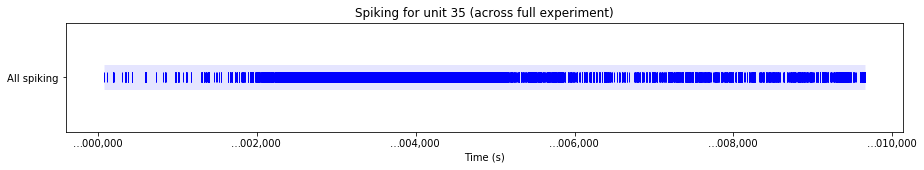

In [6]:
# Find all spike times for this cluster
spikes_t = nwbf.units['spike_times'][cluster_idx]

# Since we don't have a true start/end time of the recording session, we use
# the time of first and last spike as the start/stop valid interval, assuming
# no recording dropouts for the duration of the experiment
valid_intervals = TimeIntervals(np.array([spikes_t[0], spikes_t[-1]]))

# Build a PointData object with the spike times and valid intervals
spiking_all = PointData(point_times=spikes_t, valid_intervals=valid_intervals)

print('*** Spiking for cluster %s ***' % cluster_idx)
print('# of spikes = %d' % spiking_all.point_times.shape[0])
print('# of valid intervals = %d' % len(spiking_all.valid_intervals))
print('duration of valid intervals = %0.2f s' % np.sum(spiking_all.valid_intervals.durations()))
print('SNR = %0.2f' % nwbf.units['snr'][cluster_idx])
print('\n')

f = plt.figure(1, figsize=(15, 2))
ax1 = f.add_subplot(1, 1, 1)
spikeplots = [(spiking_all, 'All spiking')]
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s (across full experiment)' % cluster_idx)

pass

### Time Queries: Query for cluster spiking in the different epoch types
#### PointData (spiking), TimeIntervals (stimulus type) --> PointData (spiking)
Query for the unit's spiking only in epochs when the animal experienced each of the different stimulus types. This is our first example of a <i>time query</i>, one of the fundamental query types. In this case we extract the time intervals (array of start/stop times) for all epochs of a given stimulus type, and we query into the unit's spiking data to only get data in these intervals. The intersection of valid intervals is handled automatically behind the scenes.

Time queries into the spiking data for cluster 35
yields spiking and valid intervals for each stimulus type...

*** Spiking during Natural Images epochs ***
# of spikes = 499
# of valid intervals = 3
total duration of valid intervals = 1488.74 s


*** Spiking during drifting_gratings epochs ***
# of spikes = 2119
# of valid intervals = 630
total duration of valid intervals = 1261.07 s


*** Spiking during flash_250ms epochs ***
# of spikes = 14
# of valid intervals = 150
total duration of valid intervals = 37.56 s


*** Spiking during gabor_20_deg_250ms epochs ***
# of spikes = 69
# of valid intervals = 1
total duration of valid intervals = 912.00 s


*** Spiking during natural_movie_1 epochs ***
# of spikes = 1061
# of valid intervals = 2
total duration of valid intervals = 600.50 s


*** Spiking during natural_movie_3 epochs ***
# of spikes = 3444
# of valid intervals = 2
total duration of valid intervals = 1201.00 s


*** Spiking during spontaneous_activity epochs ***
# of spikes = 

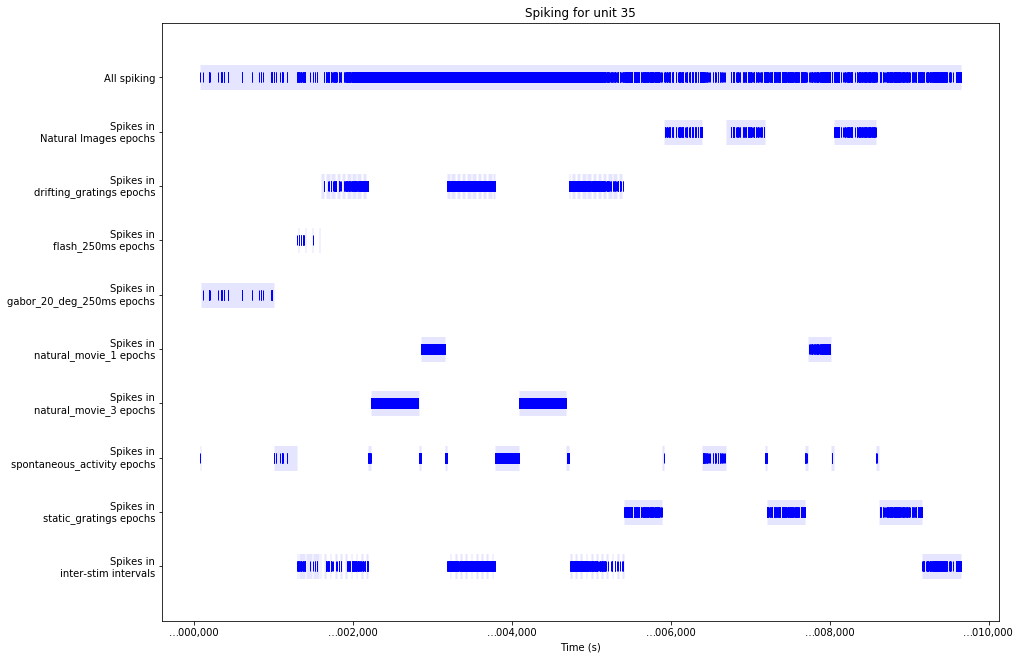

In [7]:
print("Time queries into the spiking data for cluster {0}\n".format(cluster_idx) + 
      "yields spiking and valid intervals for each stimulus type...\n")

# Within the loop, we will add a timeseries to this list for each stimulus type
spikeplots = [(spiking_all, 'All spiking')]

# Loop over all stimulus types, doing a TIME QUERY for spiking of the cluster during that stimulus type
for stim in np.unique(stim_types):

    # Get the time intervals of the epochs with this stimulus type
    epochs_this_stim = np.where(stim_types==stim)[0]
    ivls_array = epoch_ivls_array[epochs_this_stim, :]
    query_intervals = TimeIntervals(ivls_array)
    
    # Execute at TIME QUERY on spiking during epochs of interest
    spiking_behav = spiking_all.time_query(query_intervals)
    
    # append this stimulus type's spiking to the list for later plotting
    spikeplots.append((spiking_behav, 'Spikes in\n%s epochs' % stim))

    print('*** Spiking during %s epochs ***' % stim)
    print('# of spikes = %d' % spiking_behav.point_times.shape[0])
    print('# of valid intervals = %d' % len(spiking_behav.valid_intervals))
    print('total duration of valid intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))
    print('\n')
    
# Also analyze the inter-stimulus intervals
query_intervals = TimeIntervals(isi_ivls_array)
spiking_behav = spiking_all.time_query(query_intervals)  # time query
spikeplots.append((spiking_behav, 'Spikes in\ninter-stim intervals'))
print('*** Spiking during inter-stim intervals ***')
print('# of spikes = %d' % spiking_behav.point_times.shape[0])
print('# of valid intervals = %d' % len(spiking_behav.valid_intervals))
print('total duration of valid intervals = %0.2f s' % np.sum(spiking_behav.valid_intervals.durations()))
print('\n')


# Plot spiking for all stimulus types
fig1 = plt.figure(1, figsize=(15, len(spikeplots)+1))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s' % cluster_idx)

pass # suppress output

### Time Queries: Query for cluster spiking during a single epoch of a given stimulus type
#### 1. PointData (all spiking), TimeIntervals (stimulus type) --> PointData (spiking during a stim type)
#### 2. PointData (spiking during a stim type), TimeIntervals (epoch) --> PointData (spiking during one stim epoch)
Let's look specifically at one stimulus type, and then zoom in on a single epoch of that stimulus type.  Both of these are time queries on PointData objects.

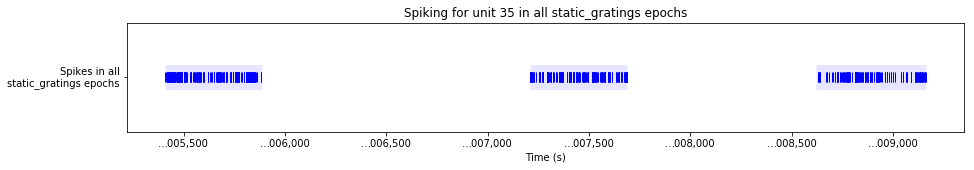

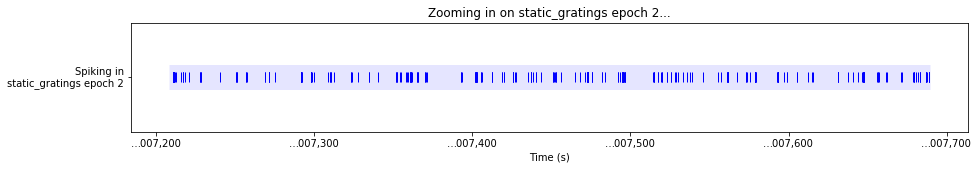

In [8]:
spikeplots = []

epochs_this_stim = np.where(stim_types==stim_of_interest)[0]
ivls_array = epoch_ivls_array[epochs_this_stim, :]
query_intervals = TimeIntervals(ivls_array)
    
# Execute at TIME QUERY on spiking during epochs of interest
spiking_during_stim = spiking_all.time_query(query_intervals)
    
# append this stimulus type's spiking to the list for later plotting
spikeplots.append((spiking_during_stim, 'Spikes in all\n%s epochs' % stim_of_interest))


# Plot spiking
fig1 = plt.figure(1, figsize=(15, len(spikeplots)+1))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s in all %s epochs' % (cluster_idx, stim_of_interest))


# Query for spiking in just the first epoch of this stimulus type
spiking_first_stim = spiking_all.time_query(query_intervals[epoch_of_interest])

fig2 = plt.figure(2, figsize=(15,2))
ax2 = fig2.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_first_stim, 'Spiking in\n%s epoch %d' % (stim_of_interest, epoch_of_interest+1))], axis=ax2)
ax2.set_title("Zooming in on %s epoch %d..." % (stim_of_interest, epoch_of_interest+1))


pass # suppress output

### Dataset Query + Time Query: spiking for many clusters during a single epoch of a given stim type
#### 1. Dataset Query: NWBFile (one animal) --> n PointData (n units' spiking)
#### 2. Time Query: n PointData (n units' spiking) --> n PointData (n units' spiking during one stim epoch)
First get the spiking data for a subset of the units, and then do a time query for the units' spiking during a single epoch.


processing spiking data for 100 units in static_gratings epoch 2...



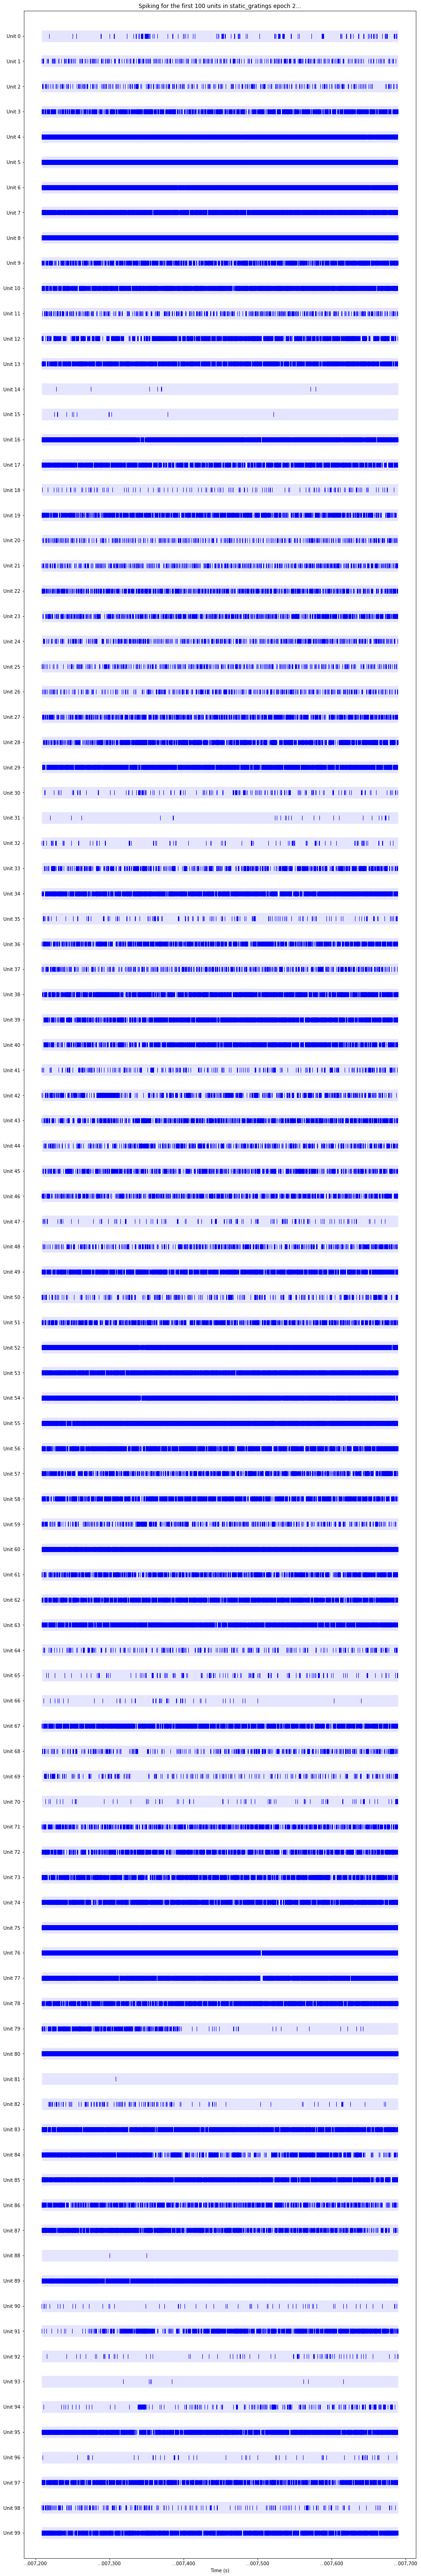

In [9]:
num_units = 100
print('processing spiking data for %d units in %s epoch %d...\n' % (num_units, stim_of_interest, epoch_of_interest+1))

# ---------------------
# 1. Dataset Queries for the first num_units units' spiking
# ---------------------
spikes_all_clusters = np.array(nwbf.units['spike_times'][:])
all_unit_spiking = []
for i in range(num_units):
    spikes = spikes_all_clusters[i]
    valid_start = min(min(spikes[0], isi_ivls_array[0, 0]), epoch_ivls_array[0, 0])
    valid_end = max(max(spikes[-1], isi_ivls_array[-1, 1]), epoch_ivls_array[-1, 1])
    valid_intervals = TimeIntervals(np.array([valid_start, valid_end]))
    spiking = PointData(point_times=spikes, valid_intervals=valid_intervals)
    all_unit_spiking.append(spiking)
    
    
# ---------------------
# 2. Time Queries for the first num_units units' spiking during a single epoch
#    of a given stimulus type (same epoch from previous cell)
# ---------------------
spikeplots = []
for i, unit_spiking in enumerate(all_unit_spiking):
    spiking_during_epoch = unit_spiking.time_query(query_intervals[epoch_of_interest])
    spikeplots.append((spiking_during_epoch, 'Unit %d' % i))
    
f = plt.figure(1, figsize=(15, 100))
ax1 = f.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for the first %d units in %s epoch %d...' % (num_units, stim_of_interest, epoch_of_interest+1))

pass

### Dataset Query + Time Query: Investigate animal speed
#### 1. Dataset Query: NWBFile (one animal) --> ContinuousData (speed across all epochs)
#### 2. Time Query: ContinuousData (speed), epoch --> ContinuousData (speed in one epoch)
First, query for the animal's speed data across all epochs. This is our first example of a ContinuousData object, which represents data that are, in theory, a continuous function of time.  For example, the animal theoretically has a speed at all time points, but we only sample it with some regular sampling rate. We represent this as a set of valid intervals (i.e. observation intervals), within which we have pairs of sample times (i.e. timestamps) and samples (i.e. the speed measurements). As with unit spiking, we always keep track of the valid intervals over which it was possible for us to be measuring the animal's behavior, not just lists of timestamps and samples.

We then do a time query into the ContinuousData object to extract the animal speed during a single epoch. Note that, as with PointData, time queries automatically handle the intersection of valid intervals. The returned ContinuousData object's valid intervals will be the intersection of the original valid intervals and the intervals of the time query. 

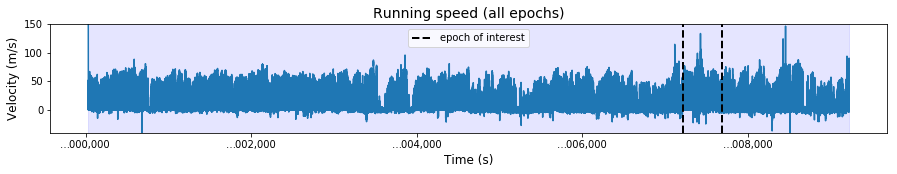

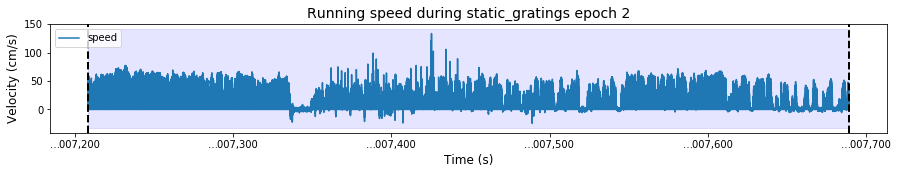

In [14]:
# ------------
# 1. Dataset query: animal speed across all epochs
# ------------
speed_timeseries = nwbf.modules['running']['speed']
sample_times = speed_timeseries.timestamps[()]
speed_valid_intervals = TimeIntervals(np.array([sample_times[0], sample_times[-1]]))
speed_all_epochs = ContinuousData(samples=pd.DataFrame(data=speed_timeseries.data[()], columns=['speed']), 
                                  sample_times=sample_times, 
                                  valid_intervals=speed_valid_intervals)

f = plt.figure(figsize=(15,2))
ax = f.add_subplot(1, 1, 1)
plot_ContinuousData(speed_all_epochs, axis=ax)
plt.ylim(-40, 150)
plt.title('Running speed (all epochs)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (m/s)', fontsize=12)

l = ax.axvline(query_intervals[epoch_of_interest].to_array()[0][0], color='k', linestyle='--', linewidth=2)
ax.axvline(query_intervals[epoch_of_interest].to_array()[0][1], color='k', linestyle='--', linewidth=2)
ax.legend([l], ['epoch of interest'])


# ------------
# 2. Time query: animal speed in a single epoch of interest
# ------------
speed_one_epoch = speed_all_epochs.time_query(query_intervals[epoch_of_interest])

f = plt.figure(figsize=(15,2))
ax1 = f.add_subplot(1, 1, 1)
plot_ContinuousData(speed_one_epoch, axis=ax1)
plt.title('Running speed during %s epoch %d' % (stim_of_interest, epoch_of_interest+1), fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Velocity (cm/s)', fontsize=12)

ax1.axvline(query_intervals[epoch_of_interest].to_array()[0][0], color='k', linestyle='--', linewidth=2)
ax1.axvline(query_intervals[epoch_of_interest].to_array()[0][1], color='k', linestyle='--', linewidth=2)
pass

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> EventData (time periods where animal speed > threshold)
We now compute an analysis function on our speed data to find all of the time intervals where the animal was running faster than a threshold. This returns and EventData object, which is our way of representing the occurence of "events" (i.e. time intervals) that occur within some observation interval.  This is very similar to PointData--which we used to represent spiking--except instead of just timestamps, here we instead have start/stop times (i.e. time intervals) occuring at various points throughout our observation interval.

Finding all time intervals in this epoch where animal speed > 50 cm/s...

*** Times where speed > 50 cm/s ***
# of events = 2501
duration of events = 32.64 s
# of valid intervals = 1
duration of intervals = 481.07 s


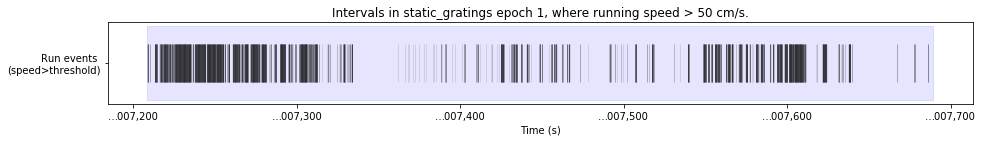

In [23]:
print('Finding all time intervals in this epoch where animal speed > %d cm/s...\n' % speed_threshold)

speed_threshold_fn = lambda x: x > speed_threshold

speed_events = speed_one_epoch.filter_intervals(speed_threshold_fn)

print('*** Times where speed > {} cm/s ***'.format(speed_threshold))
print('# of events = %d' % len(speed_events.event_intervals))
print('duration of events = %0.2f s' % np.sum(speed_events.durations()))
print('# of valid intervals = %d' % len(speed_events.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(speed_events.valid_durations()))

# TODO: Plot continuous speed
fig1 = plt.figure(1, figsize=(15.5,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_EventData(speed_events, axis=ax1)
ax1.set_title('Intervals in %s epoch %d, where running speed > %d cm/s.' % (stim_of_interest, epoch_of_interest, speed_threshold))
ax1.set_yticks([1])
ax1.set_yticklabels(['Run events \n(speed>threshold)']) # eventually use metadata from PointData object
pass # suppress output

### Time Query: spiking during one epoch, only in intervals where speed > threshold
#### PointData (spiking in one epoch), EventData (bouts where speed > threshold) --> PointData (spiking during one epoch during bouts when speed > threshold)
Now, we use all of those "fast running events" to do a time query into the unit spiking, giving us only the spiking data that occurs within any of those events. Here the imporatance of valid intervals is obvious, as we are intersecting the unit's spiking with potentially thousands of short time intervals (i.e. the "fast running events").

Finding unit spiking during intervals where animal speed > 50 m/s...

*** Spiking where speed > threshold ***
# of spikes = 15
# of intervals = 2501
duration of intervals = 32.64 s



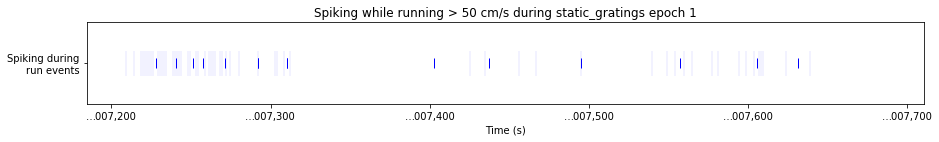

In [24]:
print('Finding unit spiking during intervals where animal speed > %d m/s...\n' % speed_threshold)

# time query using EventData as the argument (instead of TimeIntervals as we have been doing above)
spiking_run = spiking_first_stim.time_query(speed_events)  

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.point_times))
print('# of intervals = %d' % len(spiking_run.valid_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.valid_intervals.durations()))
print()

# print(spiking_run)

# Plot spiking
fig1 = plt.figure(1, figsize=(15,1.5))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_run, 'Spiking during\nrun events')], axis=ax1)
plt.title('Spiking while running > {0} cm/s during {1} epoch {2}'.format(speed_threshold, stim_of_interest, epoch_of_interest))

pass # suppress output

### Time Queries: Spiking of one unit during all drifting gradients epochs
#### 1. PointData (spiking all epochs), TimeIntervals (drifting gradient epochs) --> PointData (spiking during all drifting gradient epochs)
#### 2. PointData (spiking during all drifiting gradient epochs), TimeIntervals (a time interval of interest) --> PointData (spiking during drifting grating epochs that overlap with the query time interval)
Now let's switch gears and look at specifically at the "Drifting Gradient" stimulus. This stimulus is interesting because each epoch (i.e. stimulus presentation) has a particular gradient orientation, so we can look for tuning curves and the like.  In this cell, we first extract the unit's spiking during all of the drifting gradients epochs. Note that there are actually many very short epochs, arranged into three broader "periods" (Fig. 1 below). 

We then query for a smaller time window of interest, extracting just the spiking that overlaps with that window (Fig. 2 below).  This example shows that time queries don't have to overlap with entire epochs, but rather can actually extract any time interval of interest. The time query handles the intersection of valid intervals behind the scenes. 

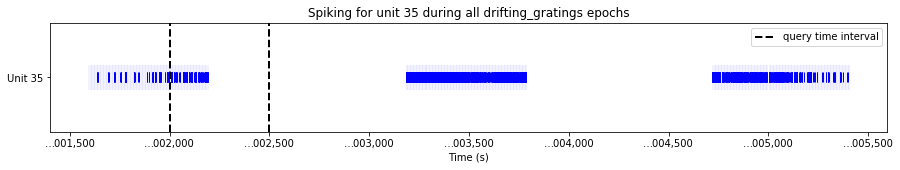

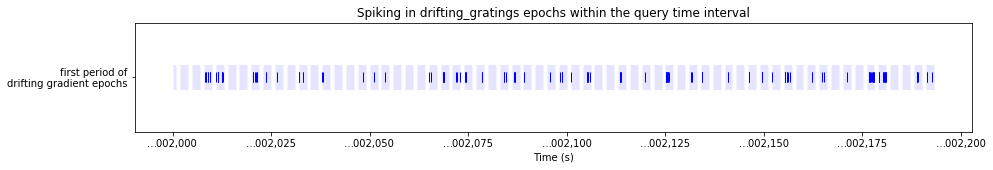

In [34]:
stim_type = 'drifting_gratings'

# Get the time intervals for epochs of this stim type
epochs_this_stim = np.where(stim_types==stim_type)[0]
query_intervals = TimeIntervals(epoch_ivls_array[epochs_this_stim, :])

spikeplots = []

# Execute at TIME QUERY on spiking during the time intervals of this stim type
spiking_behav = spiking_all.time_query(query_intervals)

spikeplots.append((spiking_behav, 'Unit %d' % cluster_idx))

fig1 = plt.figure(1, figsize=(15, len(spikeplots)+1))
ax1 = fig1.add_subplot(1, 1, 1)
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s during all %s epochs' % (cluster_idx, stim_type))
l = ax1.axvline(2000, color='k', linestyle='--', linewidth=2)
ax1.axvline(2500, color='k', linestyle='--', linewidth=2)
plt.legend([l], ['query time interval'])

# Time query
first_period = TimeIntervals(np.array([2000, 2500]))
spiking_first_period = spiking_behav.time_query(first_period)

fig2 = plt.figure(2, figsize=(15, 2))
ax2 = fig2.add_subplot(1, 1, 1)
plot_PointData_multiple([(spiking_first_period, 'first period of\ndrifting gradient epochs')], axis=ax2)
plt.title('Spiking in %s epochs that overlap with the query time interval\n(note that we dont return )' % (stim_type))
pass

### Time Queries: One cell's spiking in response to different gradient orientations
Now we use a succession of time queries to extract the unit's spiking only during epochs in which particular orientations of the drifiting grating stimulus was presented to the animal (Fig. 1 below).  We can then look at the distributions of spike counts in epochs of each orientation (Fig. 2 below).

Note: Time queries on units with many spikes can be currently be pretty slow, because we have to check whether each spike falls within any of the query intervals. You can search for one spike in order log(# query intervals), but without parallelizing over spikes this can still get costly, especially when we start doing dozens of time queries on hundreds of cells, each with tens of thousands of spikes.

/Users/ericmiller/anaconda/envs/pynwb/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


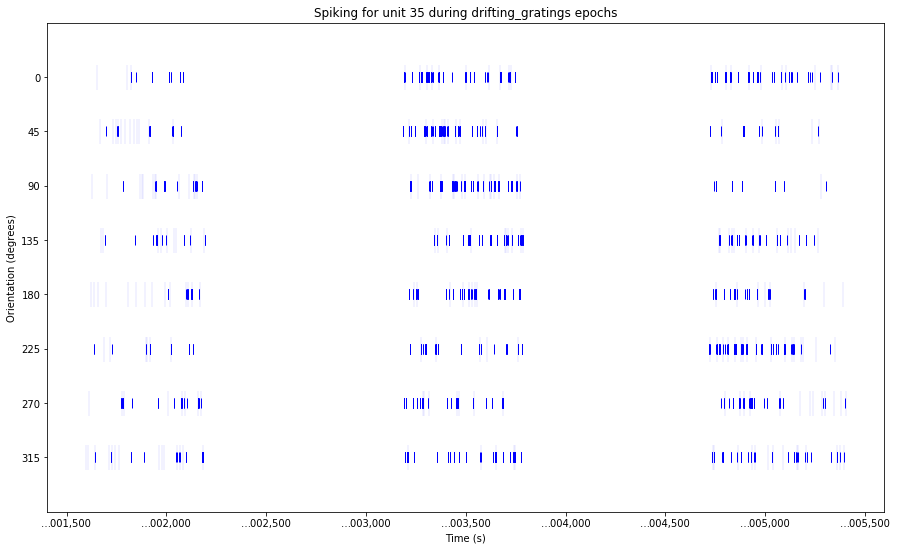

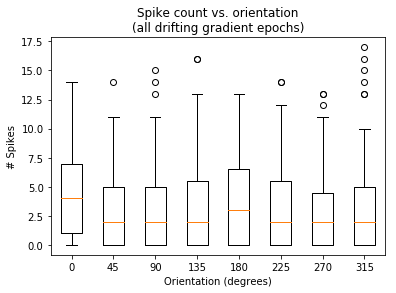

In [26]:
# Get the orientations and epoch intervals for each epoch of this stim type
all_epochs_ori = nwbf.epochs['Ori'][:]
stim_ori = all_epochs_ori[epochs_this_stim]  # orientation for all epochs of this stim type
stim_ivls = epoch_ivls_array[epochs_this_stim, :]  # time intervals for all epochs of this stim type

# Get the set of all possible orientations (removing 'nan') 
possible_ori = np.unique(stim_ori)
possible_ori = possible_ori[~np.isnan(possible_ori)]

spikeplots = []
rate_vs_ori = {ori: [] for ori in possible_ori}

# For each possible orientation, get the distribution of firing of this cell
for i, ori in enumerate(possible_ori):
    # Get the time intervals for epochs of this orientation
    this_ori_epochs = np.where(stim_ori==ori)[0]
    this_ori_ivls = TimeIntervals(stim_ivls[this_ori_epochs, :])
    
    # Do a Time Query on just the epochs with this orientation
    this_ori_spiking = spiking_all.time_query(this_ori_ivls)
    spikeplots.append((this_ori_spiking, int(ori)))
    
    for ivl in this_ori_ivls:
        ivl_spiking = this_ori_spiking.time_query(TimeIntervals(ivl))
        ivl_spike_count = len(ivl_spiking.point_times)
        ivl_length = ivl_spiking.valid_intervals.durations()[0][0]
        rate_vs_ori[ori].append(ivl_spike_count)
    
fig1 = plt.figure(1, figsize=(15, len(spikeplots)+1))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_ylabel('Orientation (degrees)')
plot_PointData_multiple(spikeplots, axis=ax1)
plt.title('Spiking for unit %s during %s epochs' % (cluster_idx, stim_type))



plt.figure()
plt.title('Spike count vs. orientation\n(all drifting gradient epochs)')
plt.xlabel('Orientation (degrees)')
plt.ylabel('# Spikes')
ax = plt.subplot(111)
plt.boxplot([rate_vs_ori[ori] for ori in possible_ori])
ax.set_xticklabels([int(ori) for ori in possible_ori])
pass